# Nearshoring

Análisis pertinente al decreto de Nearshoring propuesta por la [Secretaría de Economía](https://www.gob.mx/shcp/prensa/comunicado-no-68-gobierno-de-mexico-fortalece-inversiones-por-nearshoring-en-todo-el-pais?idiom=es) en México. Para esto, se filtraron los datos de las unidades económicas pertinentes, utilizando el DENUE 2022 y se agruparon los datos por hexágonos de H3 con resolución 5. Posteriormente, los datos se normalizaron utilizando todas las unidades económicas.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import folium

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_119144/81123683.py:6: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


2024-01-12 16:54:38 Configured OSMnx 1.1.2
2024-01-12 16:54:38 HTTP response caching is on


## Download data

### DENUE Industry

In [2]:
year = '20'
table = 'denue_2020'
query = f"SELECT * FROM denue.{table} WHERE \"codigo_act\" LIKE \'31%%\'or \"codigo_act\" LIKE \'32%%\'or \"codigo_act\" LIKE \'33%%\' or \"codigo_act\" LIKE \'51211%%\'"
query

'SELECT * FROM denue.denue_2020 WHERE "codigo_act" LIKE \'31%%\'or "codigo_act" LIKE \'32%%\'or "codigo_act" LIKE \'33%%\' or "codigo_act" LIKE \'51211%%\''

In [3]:
denue_all = aup.gdf_from_query(query)
print(denue_all.shape)
denue_all.head(2)

(604612, 42)


,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipo_uni_eco,latitud,longitud,fecha_alta,geometry
0,32374.0,4 HERMANOS,None,311812,Panificación tradicional,31 a 50 personas,CALLE,LIMA,CALLE,NARANJO,...,2047,32.0,4499169000.0,AGELICADELHER@HOTMAIL.COM,None,Fijo,21.872900,-102.30863,2014-12,POINT (-102.30863 21.87290)
1,17544.0,ADRIVER,ADRIVER SA DE CV,314120,"Confección de cortinas, blancos y similares",6 a 10 personas,CALLE,RINCON DE ROMOS,CALLE,SAN FRANCISCO DE LOS ROMO,...,2278,28.0,4499140600.0,FACTURAS_ADRIVER@HOTMAIL.COM,None,Fijo,21.909044,-102.30418,2010-07,POINT (-102.30418 21.90904)


In [4]:
denue_all.per_ocu.unique()

array(['31 a 50 personas', '6 a 10 personas', '251 y más personas',
       '11 a 30 personas', '0 a 5 personas', '51 a 100 personas',
       '101 a 250 personas'], dtype=object)

In [5]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325,
                '0 A 5 PERSONAS': 3,
                '6 A 10 PERSONAS':8,
                '11 A 30 PERSONAS':20,
                '31 A 50 PERSONAS':40,
                '51 A 100 PERSONAS':75,
                '101 A 250 PERSONAS':175,
                '251 Y MAS PERSONAS':325,
                'NO ESPECIFICADO':0,
                '251 y mÃ¡s personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [6]:
denue_all['per_ocu_num_tot'] = denue_all.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

In [7]:
# denue_all = denue_all.drop(columns='index_right')

### Industrias nearshoring

In [8]:
query = f"""SELECT * FROM denue.{table} WHERE \"codigo_act\" LIKE \'3363%%\'or \"codigo_act\" LIKE \'3254%%\'
or \"codigo_act\" LIKE \'3359%%\' or \"codigo_act\" LIKE \'3344%%\' or \"codigo_act\" LIKE \'3253%%\' or \"codigo_act\" LIKE \'3391%%\' or
\"codigo_act\" LIKE \'3253%%\' or \"codigo_act\" LIKE \'33641%%\' or  \"codigo_act\" LIKE \'3345%%\'  or  \"codigo_act\" LIKE \'51211%%\' """
query

'SELECT * FROM denue.denue_2020 WHERE "codigo_act" LIKE \'3363%%\'or "codigo_act" LIKE \'3254%%\'\nor "codigo_act" LIKE \'3359%%\' or "codigo_act" LIKE \'3344%%\' or "codigo_act" LIKE \'3253%%\' or "codigo_act" LIKE \'3391%%\' or\n"codigo_act" LIKE \'3253%%\' or "codigo_act" LIKE \'33641%%\' or  "codigo_act" LIKE \'3345%%\'  or  "codigo_act" LIKE \'51211%%\' '

In [9]:
denue_near = aup.gdf_from_query(query)
print(denue_near.shape)
denue_near.head(4)

(7135, 42)


,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipo_uni_eco,latitud,longitud,fecha_alta,geometry
0,36214.0,FORMULAS MAGISTRALES,FORMULAS MAGISTRALES SA DE CV,325412,Fabricación de preparaciones farmacéuticas,6 a 10 personas,CALLE,RAMON LOPEZ VELARDE,CALLE,PEDRO PARGA,...,0638,11.0,nan,None,None,Fijo,21.884022,-102.293540,2014-12,POINT (-102.29354 21.88402)
1,8622267.0,MAQUILA DE AEROSOLES,SUPER AEROSOL G2 SA DE CV,325320,Fabricación de pesticidas y otros agroquímicos...,6 a 10 personas,AVENIDA,MUEBLEROS,AVENIDA,CARPINTEROS NORTE,...,0016,7.0,4494411300.0,AGSG2@HOTMAIL.COM,WWW.G2AGS.COM,Fijo,21.989230,-102.339180,2019-11,POINT (-102.33918 21.98923)
2,6710499.0,BEYONZ MEXICANA,BEYONZ MEXICANA S.A. DE C.V.,336370,Fabricación de piezas metálicas troqueladas pa...,101 a 250 personas,CIRCUITO,CEREZO SUR,CALLE,HUIZACHE,...,009A,16.0,nan,PATRICIA.OROZCO@BEYONZ.COM.MX,None,Fijo,22.038738,-102.284515,2016-01,POINT (-102.28452 22.03874)
3,6281005.0,CALSONIC KANSEI MEXICANA SA DE CV,CALSONIC KANSEI MEXICANA SA DE CV,336390,Fabricación de otras partes para vehículos aut...,251 y más personas,CIRCUITO,AGUASCALIENTES ORIENTE,CIRCUITO,AGUASCALIENTES NORTE,...,0035,4.0,nan,None,None,Fijo,21.965467,-102.278160,2010-07,POINT (-102.27816 21.96547)


In [10]:
denue_near['per_ocu_num_near'] = denue_near.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))

In [11]:
# denue_near = denue_near.drop(columns='index_right')

### Hexágonos

In [12]:
mun_gdf = aup.gdf_from_db("mpos_2020","marco")

In [13]:
gdf = mun_gdf.to_crs("EPSG:6372")
gdf = gdf.buffer(1).reset_index().rename(columns={0: "geometry"})
gdf = gdf.set_geometry("geometry")
gdf = gdf.to_crs("EPSG:4326")
# poly_wkt = gdf.dissolve().geometry.to_wkt()[0]

In [41]:
res = 8
hex_gdf = aup.create_hexgrid(gdf, res)

In [42]:
# hex_gdf = aup.gdf_from_db("hexgrid_5", "hexgrid")
print(hex_gdf.shape)
hex_gdf.head(4)

(2306941, 2)


,hex_id_8,geometry
0,88498eae9dfffff,"POLYGON ((-102.34288 21.77158, -102.33829 21.7..."
1,88498ea417fffff,"POLYGON ((-102.44072 21.72357, -102.43613 21.7..."
2,88498e3583fffff,"POLYGON ((-102.21858 22.00286, -102.21398 22.0..."
3,88498eae63fffff,"POLYGON ((-102.27323 21.70686, -102.26865 21.7..."


In [43]:
hex_gdf.to_crs("EPSG:6372").area/100000

0          8.638910
1          8.642035
2          8.637253
3          8.635205
4          8.641151
             ...   
2307378    8.666267
2307379    8.672332
2307380    8.672588
2307381    8.674100
2307382    8.667800
Length: 2306941, dtype: float64

## Spatial intersection

In [44]:
denue_in_hex = gpd.sjoin(denue_near, hex_gdf)
denue_hex = denue_in_hex.groupby([f'hex_id_{res}']).agg(['count','sum'])

/tmp/ipykernel_119144/112529287.py:2: FutureWarning: ['geometry'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  denue_hex = denue_in_hex.groupby([f'hex_id_{res}']).agg(['count','sum'])


In [45]:
denue_hex.columns = ['_'.join(col) for col in denue_hex.columns]
per_ocu_cols = [col for col in denue_hex.columns if 'per_ocu_num' in col]
denue_hex = denue_hex[per_ocu_cols]
denue_hex = denue_hex.reset_index()
hex_denue_gdf = hex_gdf.merge(denue_hex, on=f'hex_id_{res}')

In [46]:
hex_denue_gdf

,hex_id_8,geometry,per_ocu_num_near_count,per_ocu_num_near_sum
0,88498e361bfffff,"POLYGON ((-102.30091 21.89334, -102.29631 21.8...",2,16
1,88498e3655fffff,"POLYGON ((-102.28412 21.87119, -102.27953 21.8...",1,3
2,88498e36ebfffff,"POLYGON ((-102.29832 21.91719, -102.29372 21.9...",1,20
3,88498e3603fffff,"POLYGON ((-102.27594 21.88765, -102.27135 21.8...",2,6
4,88498ead91fffff,"POLYGON ((-102.25208 21.84251, -102.24749 21.8...",1,8
...,...,...,...,...
3868,8849886117fffff,"POLYGON ((-102.57667 22.75969, -102.57205 22.7...",1,3
3869,884988613bfffff,"POLYGON ((-102.56691 22.76054, -102.56229 22.7...",1,3
3870,88498861ebfffff,"POLYGON ((-102.58798 22.77447, -102.58336 22.7...",1,3
3871,8849886131fffff,"POLYGON ((-102.55715 22.76139, -102.55253 22.7...",1,8


In [47]:
denue_in_hex = gpd.sjoin(denue_all, hex_gdf)
denue_hex = denue_in_hex.groupby([f'hex_id_{res}']).agg(['count','sum'])
denue_hex.columns = ['_'.join(col) for col in denue_hex.columns]
per_ocu_cols = [col for col in denue_hex.columns if 'per_ocu_num' in col]
denue_hex = denue_hex[per_ocu_cols]
denue_hex = denue_hex.reset_index()
hex_denue_gdf = hex_denue_gdf.merge(denue_hex, on=f'hex_id_{res}')

/tmp/ipykernel_119144/3376210587.py:2: FutureWarning: ['geometry'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  denue_hex = denue_in_hex.groupby([f'hex_id_{res}']).agg(['count','sum'])


In [48]:
hex_denue_gdf.head(2)

,hex_id_8,geometry,per_ocu_num_near_count,per_ocu_num_near_sum,per_ocu_num_tot_count,per_ocu_num_tot_sum
0,88498e361bfffff,"POLYGON ((-102.30091 21.89334, -102.29631 21.8...",2,16,73,603
1,88498e3655fffff,"POLYGON ((-102.28412 21.87119, -102.27953 21.8...",1,3,69,463


### Spatial analysis

In [49]:
hex_denue_gdf = hex_denue_gdf.rename(columns={'per_ocu_num_near_count':'nearshoring_industry',
                             'per_ocu_num_tot_count':'denue'})
hex_denue_gdf['nearshoring_industry_pct'] = hex_denue_gdf['nearshoring_industry'] / hex_denue_gdf['denue']
hex_denue_gdf['nearshoring_workforce_pct'] = hex_denue_gdf['per_ocu_num_near_sum'] / hex_denue_gdf['per_ocu_num_tot_sum']
print(hex_denue_gdf.shape)
hex_denue_gdf.head(4)

(3873, 8)


,hex_id_8,geometry,nearshoring_industry,per_ocu_num_near_sum,denue,per_ocu_num_tot_sum,nearshoring_industry_pct,nearshoring_workforce_pct
0,88498e361bfffff,"POLYGON ((-102.30091 21.89334, -102.29631 21.8...",2,16,73,603,0.027397,0.026534
1,88498e3655fffff,"POLYGON ((-102.28412 21.87119, -102.27953 21.8...",1,3,69,463,0.014493,0.006479
2,88498e36ebfffff,"POLYGON ((-102.29832 21.91719, -102.29372 21.9...",1,20,6,35,0.166667,0.571429
3,88498e3603fffff,"POLYGON ((-102.27594 21.88765, -102.27135 21.8...",2,6,35,282,0.057143,0.021277


<AxesSubplot: >

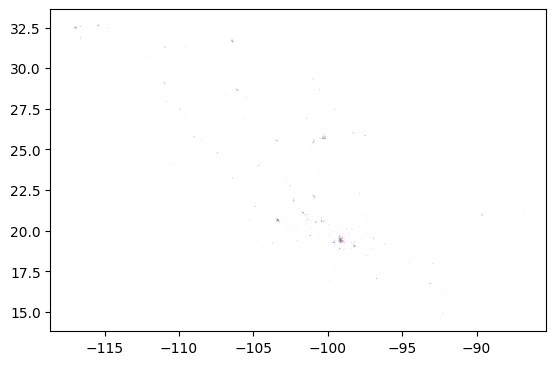

In [50]:
hex_denue_gdf.plot('nearshoring_industry')

In [26]:
m = folium.Map(tiles="cartodbpositron")

# folium.GeoJson(, name="DENUE Nearshoring").add_to(m)

folium.Choropleth(
    geo_data=hex_denue_gdf,
    name="choropleth",
    data=hex_denue_gdf,
    columns=["hex_id_7","nearshoring_industry"],
    key_on="hex_id_7",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Nearshoring industries",
).add_to(m)

folium.LayerControl().add_to(m)

display(m)

KeyError: "None of ['hex_id_7'] are in the columns"

## Save data

In [51]:
hex_denue_gdf = hex_denue_gdf.rename(columns={f'hex_id_{res}':'hex_id'})
hex_denue_gdf['res'] = res

In [52]:
hex_denue_gdf.head(2)

,hex_id,geometry,nearshoring_industry,per_ocu_num_near_sum,denue,per_ocu_num_tot_sum,nearshoring_industry_pct,nearshoring_workforce_pct,res
0,88498e361bfffff,"POLYGON ((-102.30091 21.89334, -102.29631 21.8...",2,16,73,603,0.027397,0.026534,8
1,88498e3655fffff,"POLYGON ((-102.28412 21.87119, -102.27953 21.8...",1,3,69,463,0.014493,0.006479,8


In [53]:
aup.gdf_to_db_slow(hex_denue_gdf, f'nearshoring_denue_{year}_hex', 'public_interest', if_exists='append')

In [ ]:
hex_denue_gdf.to_file(f'../../data/processed/nearshoring_res{res}.geojson')

In [ ]:
from IPython.display import display
m = folium.Map(location=(45.5236, -122.6750))
